<a href="https://colab.research.google.com/github/adamserag1/Interpretability-for-VRDU-models/blob/main/Interpretability%20Exp/lime%20(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''
Get prediction from pretrained RVL-CDIP model
- load model
- load image
- preprocess image
- get prediction

perform lime on sample for each modality
display
'''

' \nGet prediction from pretrained RVL-CDIP model\n- load model \n- load image \n- preprocess image \n- get prediction\n\nperform lime on sample for each modality \ndisplay\n'

In [8]:
pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 23.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [47]:
!pip install datasets seqeval evaluate transformers torch pytesseract lime scikit-image

In [2]:
from PIL import Image, ImageDraw, ImageFont
import evaluate
from transformers import AutoProcessor, LayoutLMv3ForSequenceClassification, set_seed
from datasets import load_dataset
import transformers as t
import torch
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


set_seed(0)

In [3]:
model = LayoutLMv3ForSequenceClassification.from_pretrained("gordonlim/layoutlmv3-base-finetuned-rvlcdip").to(device)
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [22]:
# pip install -U datasets
mini_rvl   = load_dataset(
    "dvgodoy/rvl_cdip_mini", split="validation"
)

class_names = {'0': 'letter',
            '1': 'form',
            '2': 'email',
            '3': 'handwritten',
            '4': 'advertisement',
            '5': 'scientific report',
            '6': 'scientific publication',
            '7': 'specification',
            '8': 'file folder',
            '9': 'news article',
            '10': 'budget',
            '11': 'invoice',
            '12': 'presentation',
            '13': 'questionnaire',
            '14': 'resume',
            '15': 'memo'}

dict_keys(['image', 'width', 'height', 'category', 'ocr_words', 'word_boxes', 'ocr_paragraphs', 'paragraph_boxes', 'label'])
1
['Xlkoros', 'BOOTH TEST DATA', 'ZE', 'SUMMARY SHEET', 'WNLtA', '305', 'PROJECT NO.', 'ouy', 'XEMCEL&"ZHo', 'flbnLEl', 'AxiLa', 'TITLE:', 'TyLEEE Eutux Ae{Eacs', '&Au', '%LuclaxhLL', 'DA', 'Ouihzi IILL', "YeadEster' k", '44', 'DATE;', 'Paired', 'comoirison', 'TEST METHOD: _', 'fIevor', 'deternine', 'differences', 'Scoke', 'PURPOSE:', 'PREPARATION;', 'Mukers', 'Apd_naer', 'Leduced Lghting', 'And_ahave_nrepardlloa L_', 'judges', 'PROCEOURE:', 'Walng', 'HGIL', 'Lion', 'Then', 'ney', 'insvered', '5amd| E $', 'ba/&nced', 'oresenta', 'the', 'Vions', 'the', 'ched', 'ba]lot', 'auts', 'X6D4ET', '2_XLDJCE', 'NAUuui', 'RESULTS:', 'kuv', '1.u', 'Maul"', '412', 'a uilc_:LD', '21114', 'lLi LSLLi', 'Joa', 'LisL', '0402', '214', '44', 't', '~k', 'Fanul', 'CONCLUSIONS', 'Ouutl_Ac4LlE', 'Qul zk_"\' cigt:', 'X6D4LEJ T', 'tsl-', 'Jol', 'my', '#ouo(pton _', 'Llu _', 'Ilkzp)', '[', '

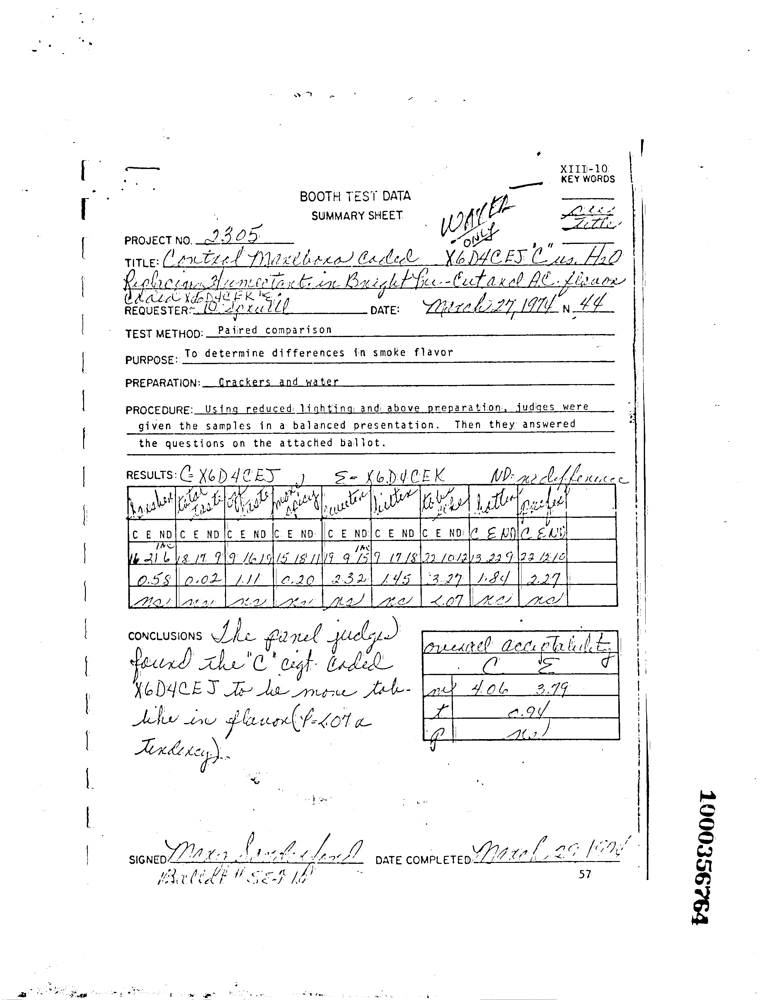

In [19]:
# Take sample from rvl
sample = mini_rvl[100] #104
image = sample['image'].convert("RGB")
words = sample['ocr_words']
bboxes = sample['word_boxes']
print(sample.keys())
print(sample['label'])
print(words)
sample['image']
# FORM

In [26]:
print(len(words))
print(bboxes)

23
[[586, 76, 614, 84], [410, 95, 607, 183], [39, 109, 228, 202], [214, 122, 423, 182], [455, 330, 589, 372], [458, 360, 611, 396], [462, 402, 554, 432], [461, 425, 577, 463], [478, 540, 508, 566], [424, 561, 512, 667], [451, 561, 476, 588], [494, 587, 509, 606], [421, 621, 483, 701], [688, 834, 701, 934], [297, 882, 438, 910], [530, 888, 590, 914], [209, 891, 285, 910], [481, 891, 535, 907], [107, 895, 205, 913], [61, 899, 103, 915], [481, 903, 535, 917], [62, 906, 286, 932], [296, 906, 402, 930]]


In [20]:
# Pass sample through model

# Logit with no perturbations => 0.9538

# words = ['UNK' for i in words]
# bboxes = [[0,0,0,0] for i in bboxes]
inputs = processor(images=[image], text=[words],boxes=[bboxes], return_tensors="pt")
inputs.to(device)

with torch.no_grad():
    outputs = model(**inputs)
logits = outputs.logits
print(logits)
predicted_class_id = logits.argmax(-1).item()
gt = sample['label']
print(f'pred -> {model.config.id2label[predicted_class_id]} actual -> {gt}')
model.config.id2label[predicted_class_id]

tensor([[-0.9538,  7.3849, -2.4934, -1.7242, -2.2957,  5.2018, -0.5007, -0.5510,
         -0.2103, -2.0204, -1.0210, -0.6517, -0.3231,  0.0479, -1.1607, -0.4476]],
       device='cuda:0')
pred -> LABEL_1 actual -> 1


'LABEL_1'

In [ ]:
print(logits)

##Text modality

When perturbing text it is important to remeber that vision and layout components must be perturbed aswell, so that the model does not infer the presence of any text

In [30]:
from lime.lime_tabular import LimeTabularExplainer
from tqdm import tqdm
import numpy as np

def make_predict_fn(model, image, boxes, words, tokenizer):
    def predict(z_bin_list):
        outputs = []
        for z_bin in tqdm(z_bin_list, desc="Perturbing and Predicting"):
            # Masked words → UNK or garbage string
            perturbed_words = [
                word if z else "[UNK]"
                for word, z in zip(words, z_bin)
            ]
            # Masked boxes → zero box
            perturbed_boxes = [
                box if z else [0, 0, 0, 0]
                for box, z in zip(boxes, z_bin)
            ]
            encoding = tokenizer(
                text=[perturbed_words],
                boxes=[perturbed_boxes],
                images=[image],
                return_tensors="pt",
                padding="max_length",
                truncation=True,
                max_length=128,
            )
            encoding = {k: v.to(device) for k, v in encoding.items()}
            with torch.no_grad():
                logits = model(**encoding).logits
                probs = torch.softmax(logits, dim=-1).cpu().numpy()
                outputs.append(probs[0])
        return np.array(outputs)
    return predict

num_tokens = len(words)

# Explainer
explainer = LimeTabularExplainer(
    training_data=np.vstack([np.ones(num_tokens), np.zeros(num_tokens)]),   # reference distribution to sample pertubed versions of input
    feature_names=words,                      # each word is a named feature
    class_names=[model.config.id2label[i] for i in range(model.config.num_labels)],
    discretize_continuous=False,
    categorical_features=list(range(num_tokens)),
    mode="classification",
    kernel_width=np.sqrt(num_tokens)
)

predict_fn = make_predict_fn(model, image, bboxes, words, processor)

# Explain the instance: we use a vector of all 1s (keep all words) as the reference
explanation = explainer.explain_instance(
    data_row=np.ones(num_tokens),         # interpretability vector
    predict_fn=predict_fn,
    num_features=30,
    num_samples=4000
)

Perturbing and Predicting:   0%|          | 0/8000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1614: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
Perturbing and Predicting: 100%|██████████| 8000/8000 [04:44<00:00, 28.16it/s]


In [31]:
weights_dict = dict(explanation.as_list())
print("Explanation score (R²):", explanation.score)
for word, weight in explanation.as_list():
  print(f"{word:10s} -> {weight:+.3f}")

Explanation score (R²): 0.43074824528991584
SUMMARY SHEET=1 -> +0.055
TITLE:=1   -> +0.046
PROJECT NO.=1 -> +0.046
BOOTH TEST DATA=1 -> -0.030
DATE;=1    -> +0.027
PREPARATION;=1 -> -0.016
PURPOSE:=1 -> +0.008
Paired=1   -> -0.008
305=1      -> +0.007
Scoke=1    -> +0.006
comoirison=1 -> +0.005
judges=1   -> +0.005
DA=1       -> +0.005
%LuclaxhLL=1 -> -0.005
Mukers=1   -> -0.004
flbnLEl=1  -> -0.004
TEST METHOD: _=1 -> +0.004
Leduced Lghting=1 -> -0.003
ney=1      -> +0.003
TyLEEE Eutux Ae{Eacs=1 -> +0.003
differences=1 -> -0.003
2_XLDJCE=1 -> -0.003
AxiLa=1    -> +0.003
2Y4]=1     -> +0.003
~k=1       -> +0.003
44=1       -> +0.003
deternine=1 -> +0.002
0402=1     -> -0.002
Ymt=1      -> -0.002
YeadEster' k=1 -> +0.002


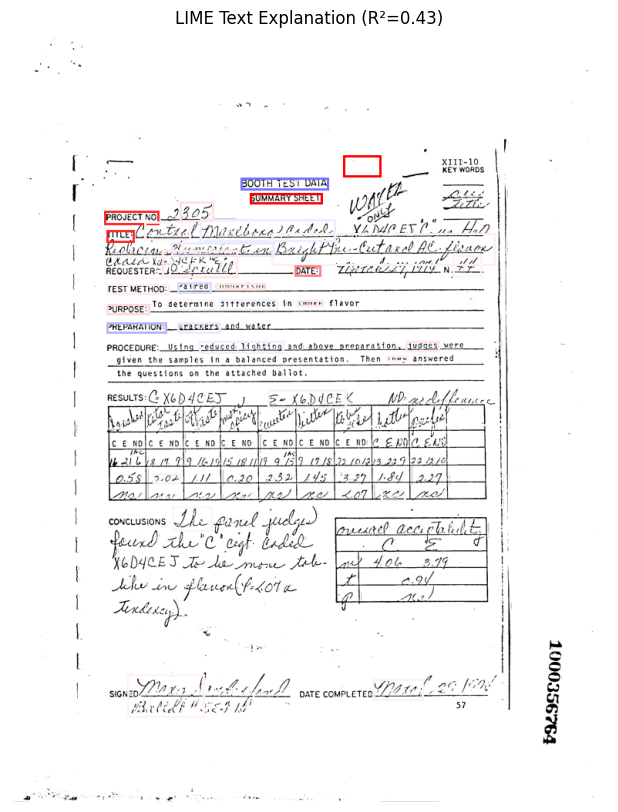

In [42]:
from PIL import ImageDraw, ImageFont
import matplotlib.pyplot as plt

weights_dict = {
    feature.split('=')[0].strip(): weight
    for feature, weight in explanation.as_list()
}

def draw_lime_token_heatmap(image, words, boxes, weights_dict):
    draw = ImageDraw.Draw(image)
    max_weight = max(abs(w) for w in weights_dict.values()) or 1.0

    for word, box in zip(words, boxes):
        if word not in weights_dict:
            continue
        weight = weights_dict[word]
        norm_weight = abs(weight) / max_weight
        intensity = int(255 * norm_weight)

        if weight > 0:
            color = (255, 255 - intensity, 255 - intensity)  # bright red → pale red
        else:
            color = (255 - intensity, 255 - intensity, 255)  # bright blue → pale blue

        draw.rectangle(box, outline=color, width=3)
        #draw.text((box[0], box[1]), word, fill=color)

    return image

highlighted_image = draw_lime_token_heatmap(image.copy(), words, bboxes, weights_dict)

plt.figure(figsize=(12, 10))
plt.imshow(highlighted_image)
plt.axis('off')
plt.title(f"LIME Text Explanation (R²={explanation.score:.2f})")
plt.show()

##Vision Modality

In [57]:
from lime import lime_image
from skimage.segmentation import slic

def make_vision_predict_fn(model, processor, words, boxes, device):
    """
    Returns a function f(images) -> probs[n_images, n_classes]
    `images` is a list of HxWxC numpy arrays produced by LIME.
    """
    def predict_fn(image_list):
        outputs = []
        for np_img in tqdm(image_list, desc="Predicting vision perturbations"):
            pil_img = Image.fromarray(np_img)
            encoding = processor(
                images=[pil_img],
                text=[words],          # keep original words
                boxes=[boxes],         # keep original layout boxes
                return_tensors="pt",
                padding="max_length",
                truncation=True,
                max_length=128,
            )
            encoding = {k: v.to(device) for k, v in encoding.items()}
            with torch.no_grad():
                logits = model(**encoding).logits
                probs = torch.softmax(logits, dim=-1).cpu().numpy()
            outputs.append(probs[0])
        return np.array(outputs)
    return predict_fn

def slic_segmentation(img):
    return slic(img, n_segments=750, compactness=10, sigma=1, start_label=1)

explainer_img = lime_image.LimeImageExplainer(random_state=0)

predict_fn_img = make_vision_predict_fn(
    model, processor, words, bboxes, device
)

# LIME works best on smaller images; resize if >1 000 px on the long edge
h, w = image.height, image.width
if max(h, w) > 1000:
    print('Resized Image')
    image_small = image.resize((w//2, h//2))
else:
    image_small = image

explanation_img = explainer_img.explain_instance(
    np.array(image_small),
    classifier_fn=predict_fn_img,
    top_labels=1,
    hide_color=(0,0,0),   # neutral grey hides BOTH ink and background
    num_samples=5000,           # ↑ stability
    segmentation_fn=slic_segmentation
)

  0%|          | 0/5000 [00:00<?, ?it/s]


Predicting vision perturbations:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1614: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(

Predicting vision perturbations: 100%|██████████| 10/10 [00:00<00:00, 22.16it/s]

Predicting vision perturbations: 100%|██████████| 10/10 [00:00<00:00, 27.95it/s]

Predicting vision perturbations: 100%|██████████| 10/10 [00:00<00:00, 27.88it/s]

Predicting vision perturbations: 100%|██████████| 10/10 [00:00<00:00, 28.13it/s]

Predicting vision perturbations: 100%|██████████| 10/10 [00:00<00:00, 28.17it/s]

Predicting vision perturbations: 100%|██████████| 10/10 [00:00<00:00, 27.94it/s]

Predicting vision perturbations: 100%|██████████| 10/10 [00:00<00:00, 27.65it/s]

Predicting vision perturbations: 100%|██████████| 10/10 [00:00<00:00, 27.50it/s]

Predicting vision perturbations: 100%|██████████| 10/10 [00:00<00:00, 28.31it/s]

P

0.5639074639529884


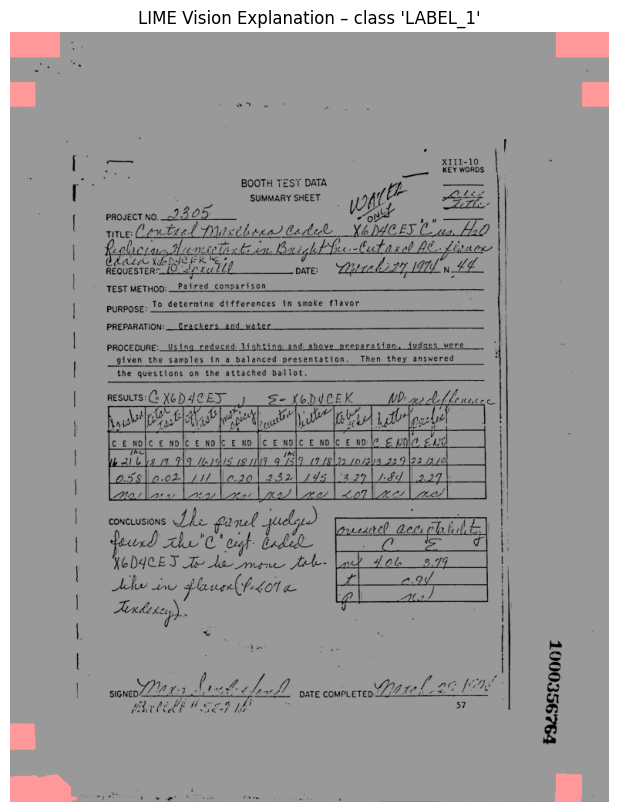

In [59]:
print(explanation_img.score)

from skimage.color import label2rgb
import matplotlib.pyplot as plt

# Get mask for the predicted class
pred_class = int(explanation_img.top_labels[0])
temp, mask = explanation_img.get_image_and_mask(
    label=pred_class,
    positive_only=False,    # show positive AND negative
    num_features=10,        # top-N super-pixels
    hide_rest=False         # keep full context
)

vis_image = label2rgb(mask, temp, bg_label=0, alpha=0.4)

plt.figure(figsize=(8,10))
plt.imshow(vis_image)
plt.axis('off')
plt.title(f"LIME Vision Explanation – class '{model.config.id2label[pred_class]}'")
plt.show()